# E. Coli Classification using AutoML TPOT: A Study Case of E Coli Dataset for Advance Machine Learning

**Video URL**: https://youtu.be/Oo734q5V_LY

**Members**:

- Ikhsan Assidiqie
- M. Ridho Sunation
- M. Hanif
- Aufa Rafiqi Muljana

A type of bacteria that commonly lives in the intestines of humans and animals. While most strains of E. coli are harmless and play a crucial role in maintaining gut health, some strains can cause severe food poisoning and other infections. These pathogenic strains can lead to symptoms such as diarrhea, urinary tract infections, respiratory illness, and more severe complications like hemolytic uremic syndrome (HUS).

Classification of E. coli using machine learning is essential for several reasons:

- Early Detection and Prevention: By classifying different strains accurately, it's possible to detect pathogenic strains early, preventing potential outbreaks and protecting public health.
- Efficient Diagnosis: Machine learning models can analyze large datasets quickly and accurately, aiding in the rapid diagnosis of infections, which is critical for timely treatment.
- Antibiotic Resistance Management: Classification helps in identifying strains that are resistant to antibiotics, enabling healthcare providers to choose the most effective treatment and manage antibiotic resistance better.
- Surveillance and Research: Machine learning aids in tracking the spread of different E. coli strains, understanding their evolution, and conducting research to develop better treatment and prevention strategies.

# Instal Library

In [1]:
# Required imports
%pip install numpy scipy scikit-learn pandas joblib torch deap update_checker tqdm stopit xgboost
%pip install dask[delayed] dask[dataframe] dask-ml
%pip install scikit-mdr skrebate
%pip install seaborn matplotlib
%pip install setuptools
%pip install niapy
%pip install numpy scipy seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Import Library

In [2]:
import pandas as pd
from scipy.io import arff
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from niapy.task import Task
from niapy.problems import Problem
from niapy.algorithms.basic import DifferentialEvolution
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

# Load The ARFF File Path

In [3]:
# Load the ARFF file
data, meta = arff.loadarff('Advanced Machine/dataset_39_ecoli.arff')

In [4]:
# Convert it into a pandas DataFrame
dataset = pd.DataFrame(data)

# Convert byte strings to normal strings for the 'class' column
dataset['class'] = dataset['class'].str.decode('utf-8')

# Display the first few rows of the DataFrame
print(dataset.head())

    mcg   gvh   lip  chg   aac  alm1  alm2 class
0  0.49  0.29  0.48  0.5  0.56  0.24  0.35    cp
1  0.07  0.40  0.48  0.5  0.54  0.35  0.44    cp
2  0.56  0.40  0.48  0.5  0.49  0.37  0.46    cp
3  0.59  0.49  0.48  0.5  0.52  0.45  0.36    cp
4  0.23  0.32  0.48  0.5  0.55  0.25  0.35    cp


# Data Exploration

In [5]:
# Check for any null values in the filtered dataset
null_data = dataset.isnull().sum()
print(null_data)

# Check the unique classes
unique_classes = dataset['class'].unique()
print(f'Unique classes: {unique_classes}')

mcg      0
gvh      0
lip      0
chg      0
aac      0
alm1     0
alm2     0
class    0
dtype: int64
Unique classes: ['cp' 'im' 'imS' 'imL' 'imU' 'om' 'omL' 'pp']


# Statistical Analysis

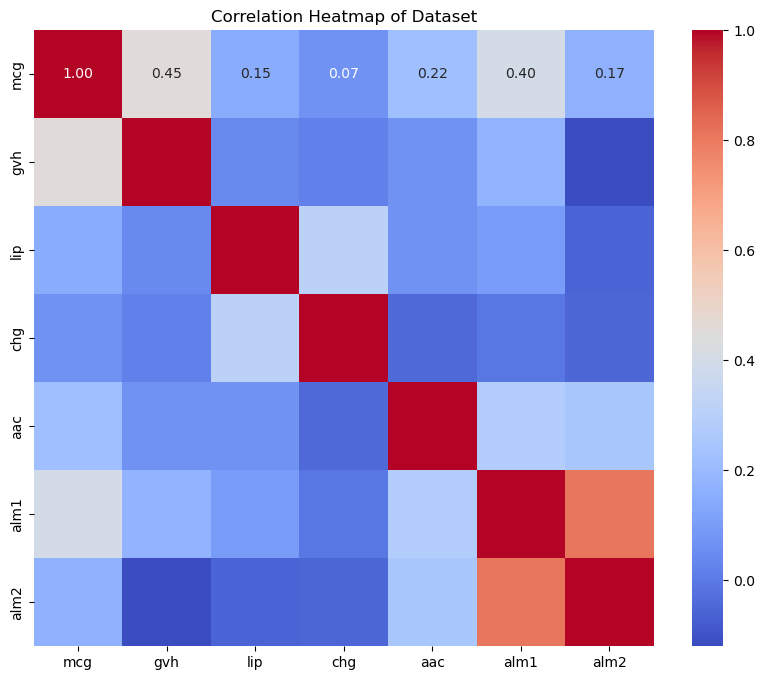

In [6]:
# Calculate the correlation matrix for numeric columns only
numeric_cols = dataset.select_dtypes(include=[np.number])
corr = numeric_cols.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Dataset')
plt.show()

In [7]:
# Convert the target variable to a categorical integer
dataset['class'] = pd.Categorical(dataset['class']).codes

# Extract the correlation values against 'class'
outcome_corr = dataset.corr()['class'].sort_values()

# Display the correlation values
print(outcome_corr)

alm2    -0.108573
chg     -0.003017
aac      0.121346
lip      0.149479
alm1     0.218806
mcg      0.642656
gvh      0.670382
class    1.000000
Name: class, dtype: float64


In [8]:
# Drop columns with correlation less than 0.15 against 'class'
filtered_dataset = dataset.drop(outcome_corr[outcome_corr < 0.15].index, axis=1)

# Show the new dataframe information
print(filtered_dataset.info())
print(filtered_dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     336 non-null    float64
 1   gvh     336 non-null    float64
 2   alm1    336 non-null    float64
 3   class   336 non-null    int8   
dtypes: float64(3), int8(1)
memory usage: 8.3 KB
None
    mcg   gvh  alm1  class
0  0.49  0.29  0.24      0
1  0.07  0.40  0.35      0
2  0.56  0.40  0.37      0
3  0.59  0.49  0.45      0
4  0.23  0.32  0.25      0


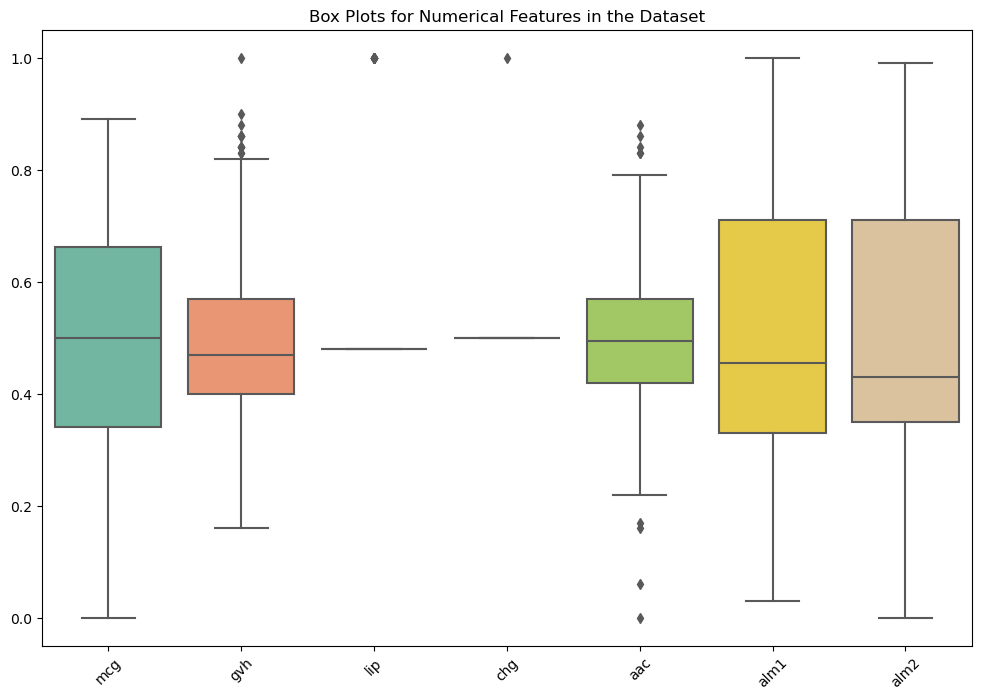

In [9]:
# Create box plots for each feature to identify outliers
plt.figure(figsize=(12, 8))
sns.boxplot(data=dataset.drop(columns=["class"]), palette="Set2")
plt.title('Box Plots for Numerical Features in the Dataset')
plt.xticks(rotation=45)  # Rotating the x labels for better visibility
plt.show()

# Outlier Detection and Capping

In [10]:
# Perform IQR capping on the previously filtered columns
Q1 = filtered_dataset.quantile(0.25)
Q3 = filtered_dataset.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Capping the outliers
capped_dataset = filtered_dataset.apply(lambda x: np.where(x < lower_bound[x.name], lower_bound[x.name], x), axis=0)
capped_dataset = capped_dataset.apply(lambda x: np.where(x > upper_bound[x.name], upper_bound[x.name], x), axis=0)

# Provide basic descriptive statistics to compare the effect
print(capped_dataset.describe())

# Verify the columns present after filtering and capping
print("Columns available for plotting:", capped_dataset.columns)

              mcg         gvh        alm1       class
count  336.000000  336.000000  336.000000  336.000000
mean     0.500060    0.498467    0.500179    2.145833
std      0.194634    0.144271    0.215751    2.645105
min      0.000000    0.160000    0.030000    0.000000
25%      0.340000    0.400000    0.330000    0.000000
50%      0.500000    0.470000    0.455000    1.000000
75%      0.662500    0.570000    0.710000    4.000000
max      0.890000    0.825000    1.000000    7.000000
Columns available for plotting: Index(['mcg', 'gvh', 'alm1', 'class'], dtype='object')


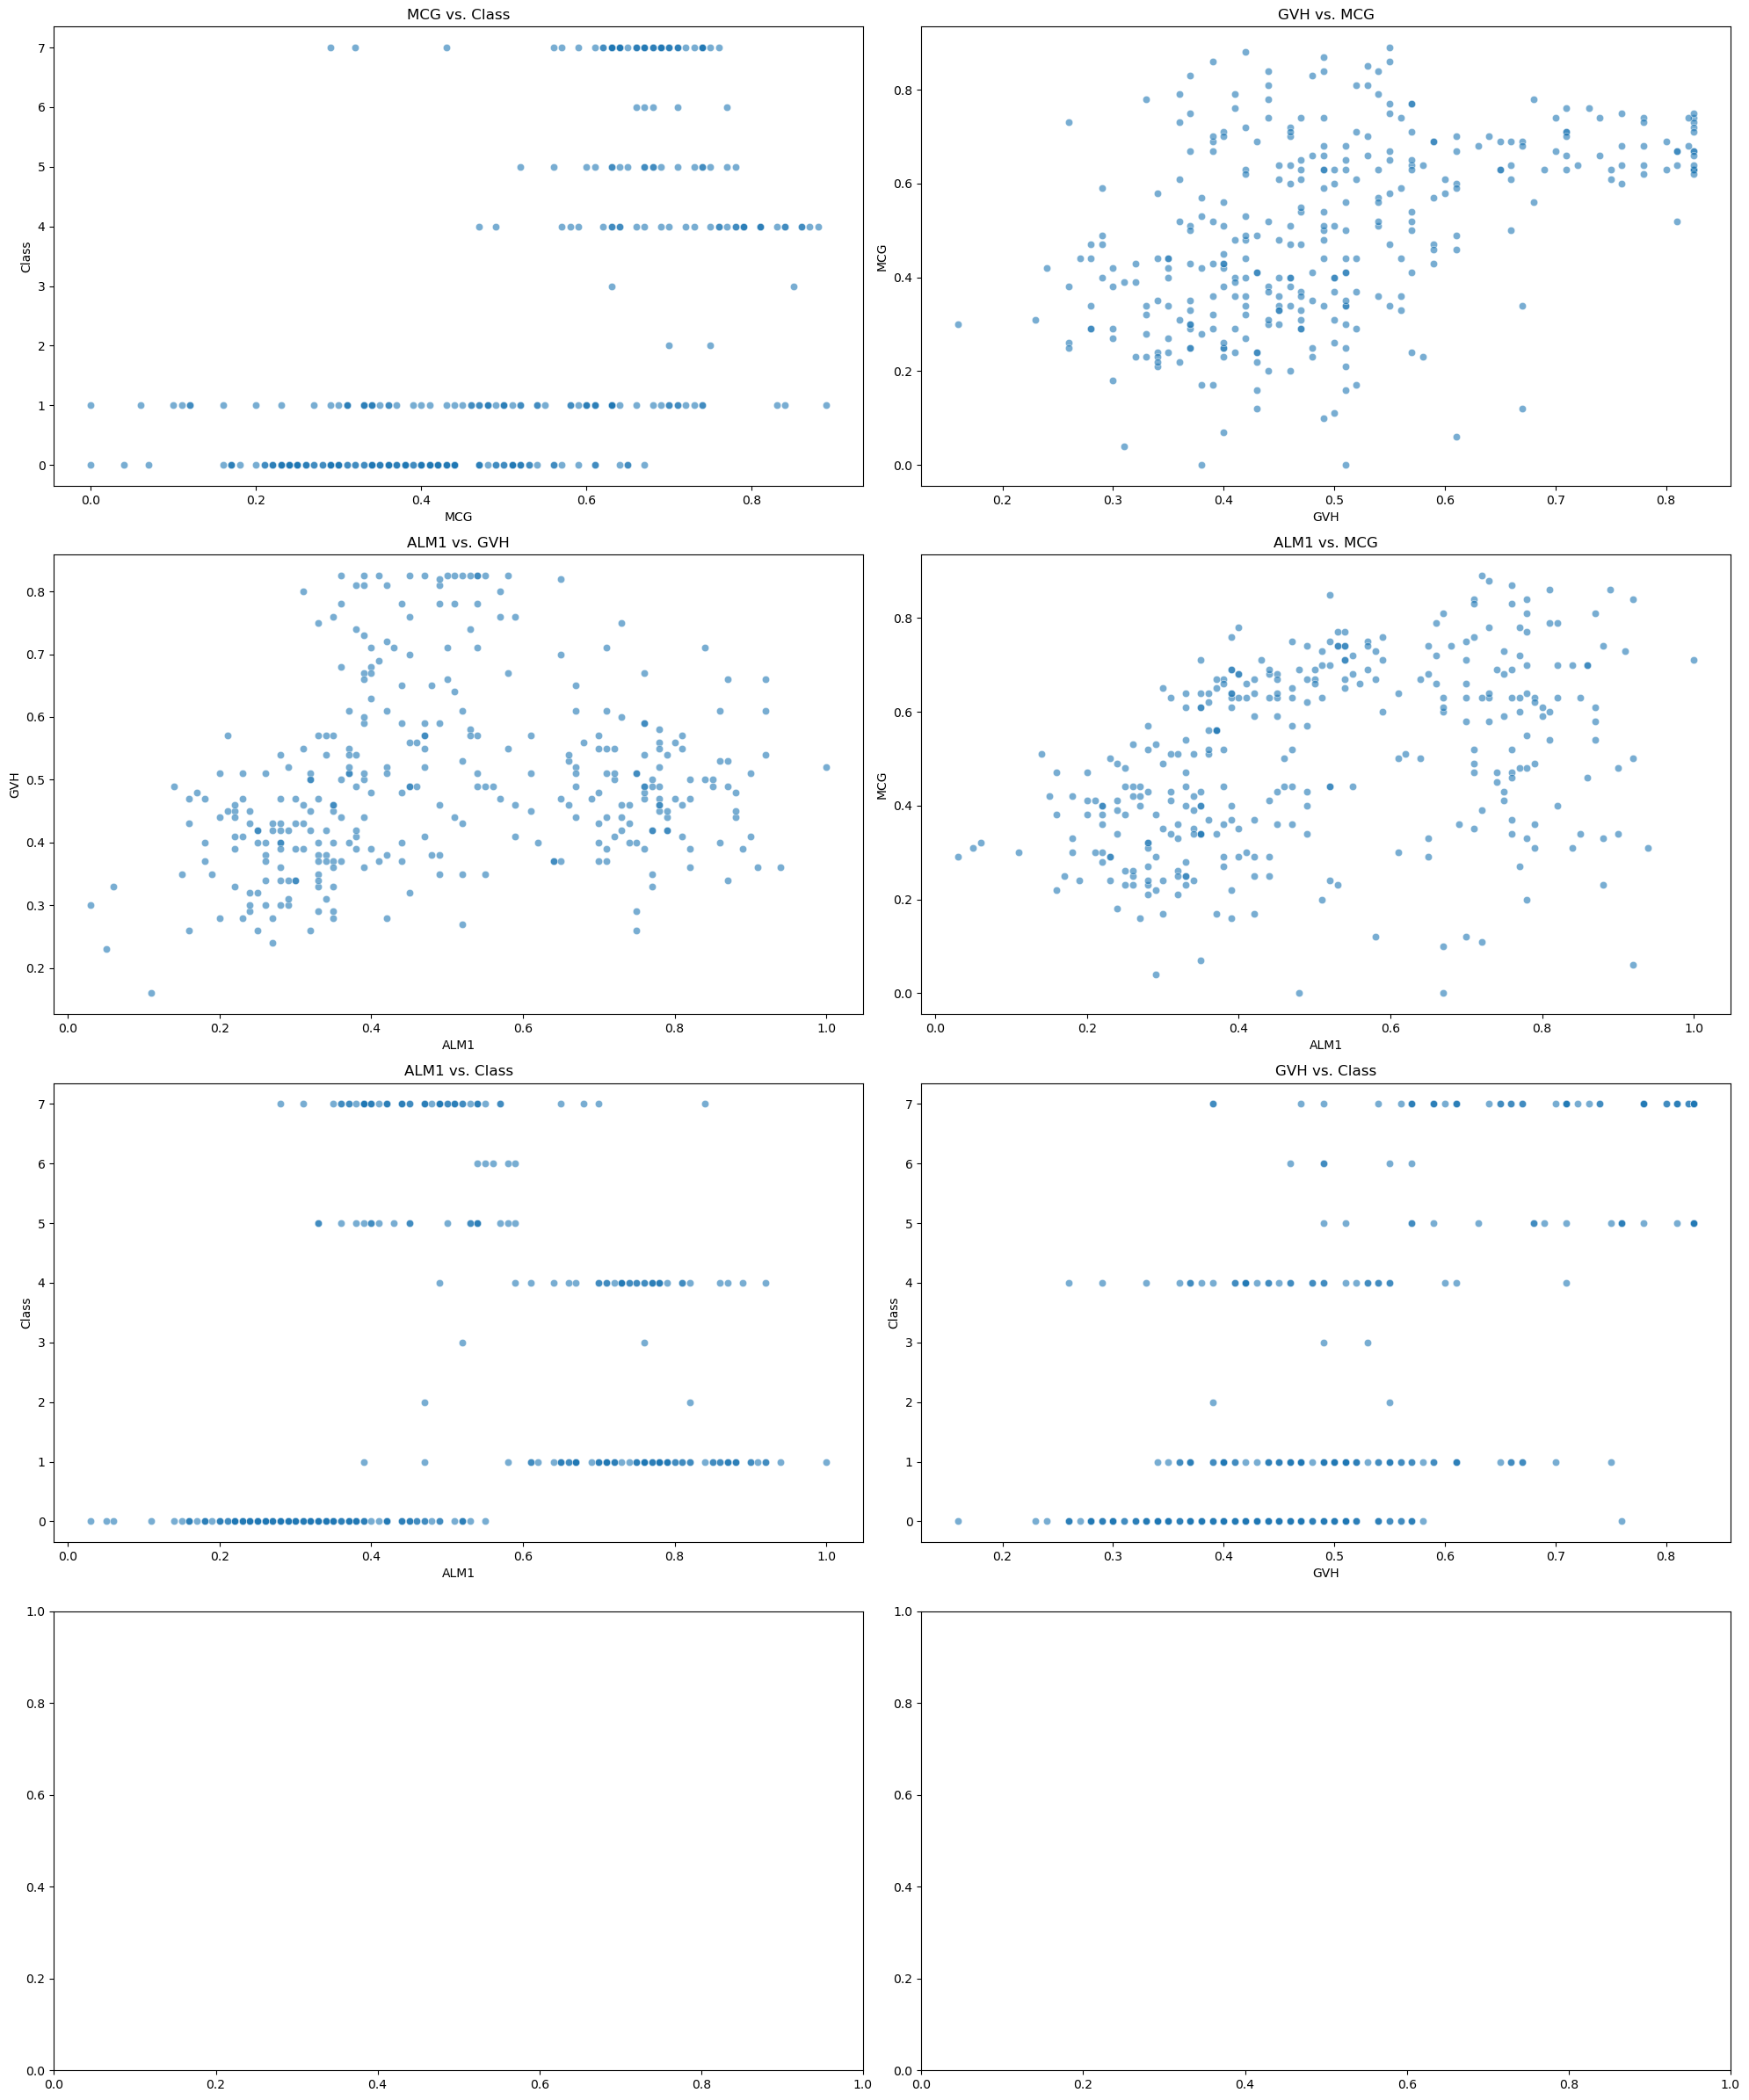

In [11]:
# Creating multiple scatter plots to visualize relationships between different variables for all classes
fig, axs = plt.subplots(4, 2, figsize=(20, 24))

# Define available columns for plotting
columns = capped_dataset.columns

# Plot 1: mcg vs. class
sns.scatterplot(data=capped_dataset, x='mcg', y='class', ax=axs[0, 0], alpha=0.6)
axs[0, 0].set_title('MCG vs. Class')
axs[0, 0].set_xlabel('MCG')
axs[0, 0].set_ylabel('Class')

# Plot 2: gvh vs. mcg
sns.scatterplot(data=capped_dataset, x='gvh', y='mcg', ax=axs[0, 1], alpha=0.6)
axs[0, 1].set_title('GVH vs. MCG')
axs[0, 1].set_xlabel('GVH')
axs[0, 1].set_ylabel('MCG')

# Plot 3: alm1 vs. gvh
sns.scatterplot(data=capped_dataset, x='alm1', y='gvh', ax=axs[1, 0], alpha=0.6)
axs[1, 0].set_title('ALM1 vs. GVH')
axs[1, 0].set_xlabel('ALM1')
axs[1, 0].set_ylabel('GVH')

# Plot 4: alm1 vs. mcg
sns.scatterplot(data=capped_dataset, x='alm1', y='mcg', ax=axs[1, 1], alpha=0.6)
axs[1, 1].set_title('ALM1 vs. MCG')
axs[1, 1].set_xlabel('ALM1')
axs[1, 1].set_ylabel('MCG')

# Plot 5: alm1 vs. class
sns.scatterplot(data=capped_dataset, x='alm1', y='class', ax=axs[2, 0], alpha=0.6)
axs[2, 0].set_title('ALM1 vs. Class')
axs[2, 0].set_xlabel('ALM1')
axs[2, 0].set_ylabel('Class')

# Plot 6: gvh vs. class
sns.scatterplot(data=capped_dataset, x='gvh', y='class', ax=axs[2, 1], alpha=0.6)
axs[2, 1].set_title('GVH vs. Class')
axs[2, 1].set_xlabel('GVH')
axs[2, 1].set_ylabel('Class')

# Check if alm2 is available for plot 7
if 'alm2' in capped_dataset.columns:
    sns.scatterplot(data=capped_dataset, x='alm2', y='class', ax=axs[3, 0], alpha=0.6)
    axs[3, 0].set_title('ALM2 vs. Class')
    axs[3, 0].set_xlabel('ALM2')
    axs[3, 0].set_ylabel('Class')
else:
    # Choose another available column for plot 7
    remaining_columns = capped_dataset.columns.difference(['mcg', 'gvh', 'alm1', 'class'])
    if not remaining_columns.empty:
        other_col = remaining_columns[0]
        sns.scatterplot(data=capped_dataset, x=other_col, y='class', ax=axs[3, 0], alpha=0.6)
        axs[3, 0].set_title(f'{other_col.upper()} vs. Class')
        axs[3, 0].set_xlabel(other_col.upper())
        axs[3, 0].set_ylabel('Class')

plt.tight_layout()
plt.show()


In [12]:
# Hyperparameter optimization class
class RFHyperparameterOptimization(Problem):
    def __init__(self, training_features, training_target, **kwargs):
        self.training_features = training_features
        self.training_target = training_target
        super().__init__(dimension=3, lower=[10, 1, 2], upper=[200, 20, 10], **kwargs)

    def _evaluate(self, x):
        n_estimators = int(x[0])
        min_samples_leaf = int(x[1])
        min_samples_split = int(x[2])
        pipeline = make_pipeline(
            MinMaxScaler(),
            RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.5,
                                   min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                                   n_estimators=n_estimators)
        )
        pipeline.fit(self.training_features, self.training_target)
        return 1.0 - pipeline.score(self.training_features, self.training_target) 

In [13]:
# Split the dataset into features and target variable
X = capped_dataset.drop('class', axis=1)
Y = capped_dataset['class']

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2)

In [14]:
# Define the optimization task
task = Task(problem=RFHyperparameterOptimization(X_train, y_train), max_evals=1000)

# Define the optimization algorithm
algorithm = DifferentialEvolution(population_size=40, differential_weight=0.5, crossover_probability=0.9)

# Run the algorithm
best_solution = algorithm.run(task)

# Extract the best hyperparameters
n_estimators = int(best_solution[0][0])
min_samples_leaf = int(best_solution[0][1])
min_samples_split = int(best_solution[0][2])

print(f'Optimized hyperparameters: n_estimators={n_estimators}, min_samples_leaf={min_samples_leaf}, min_samples_split={min_samples_split}')


Optimized hyperparameters: n_estimators=197, min_samples_leaf=1, min_samples_split=2


In [15]:
# Train the final model with the optimized hyperparameters
final_pipeline = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(bootstrap=True, criterion="entropy", max_features=0.5,
                           min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split,
                           n_estimators=n_estimators)
)
final_pipeline.fit(X_train, y_train)

# Evaluate the final model
score = final_pipeline.score(X_test, y_test)
print('Final model accuracy:', score)

Final model accuracy: 0.8088235294117647
